In [1]:
!pip install anytree

  Using cached anytree-2.8.0-py2.py3-none-any.whl (41 kB)


In [2]:
import numpy as np
import pandas as pd

from typing import List, Dict
from anytree import NodeMixin, RenderTree
from anytree.search import find_by_attr, findall_by_attr
from math import log2

pd.set_option('display.max_columns', 20)

### Loading Data

In [3]:
data  = pd.read_csv("data.csv")
data

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


### Implementing Decision Tree 

In [4]:
class DecTreeNode(NodeMixin):
    def __init__(self, name: str, attribute: str, parent = None):
        super(DecTreeNode, self).__init__()
        self.name = name
        self.attribute = attribute
        self.parent = parent
        self.attr_value = "{0}={1}".format(attribute, name)
    
    def equals(self,val):
        return (self.attr_value == val)
    
    def __str__(self) -> str:
        return self.attr_value

In [5]:
class DecTree():
    
    def __init__(self, data: pd.DataFrame, target_attribute: str):
        self.data = data
        self.target_attr = target_attribute
        self.target_attr_vals = data[target_attribute].unique()
        self.root_node = None
        self.default_pred = self.cal_default_pred()
    
    # Method to identify what should be the default prediction
    def cal_default_pred(self):
        # Count values in the target attribute
        t = self.data[self.target_attr].value_counts()
        # Default value would be that which is more frequent
        return t[t == t.max()].index[0]
        
    def pmf_target(self, df: pd.DataFrame) -> Dict[str, float]:
        # Add your code
        # To find the PMF for the target field divide value count by total count
        pmf = (df[self.target_attr].value_counts()/df[self.target_attr].count()).to_dict()
        return pmf
    
    def pmf(self,df:pd.DataFrame) -> Dict[str,float]:
        # df is of the following type
        #                     attr_val1
        # target_attr_val1      5      
        # target_attr_val2      3      
        
        # To find the pmf divide each value in the column by total sum 
        pmf = (df/df.sum()).to_dict()
        return pmf
    
    # find count of each value with respect to the target attribute value
    # It returns the following form
         
        #                     attr_val1   attr_val2
        # target_attr_val1      5            10
        # target_attr_val2      3            20 
    def attr_target_count(self, df: pd.DataFrame, attribute: str) -> pd.DataFrame:
        # get unique values from the attribute
        x_uniques = df[attribute].unique()
                
        temp_data = {}
        for x_u in x_uniques:    
            t_data = {}
            # select all those values from target attribute where attribute value is equal to x_u
            tdf = df[self.target_attr].loc[df[attribute] == x_u]
            # Iterate over target values
            for y_u in self.target_attr_vals:
                # count y_u appear in the previously created df
                t_data[y_u] = (tdf == y_u).sum()
            # this dictionary is to save next value of the attribute
            temp_data[x_u] = t_data
        # convert dictionary to data frame
        att_val_count = pd.DataFrame(temp_data)
        # remove unnecessary variables
        del temp_data, t_data, x_uniques
        return att_val_count
    
    def entropy(self, pmf: Dict[str, float]) -> float:
        # Add your code
        entr = 0
        # iterate over values of pmf
        for k,v in pmf.items():
            # if there is an error calculating the log then assign 0
            try:
                log_entr = log2(v)
            except:
                log_entr = 0
            # multiply log2 of pmf with real pmf and add the result to entr variable
            entr += v * log_entr
        # multiply minus with the entr value
        entr *= -1
        return entr
    
    # Calculate entropy for the target attribute
    def cal_entropy_df(self, df: pd.DataFrame) -> float:
        # find the pmf
        pmf = self.pmf_target(df)
        entr = self.entropy(pmf)
        return entr
    
    # Expected information retuns weighted sum of the entropies of values of an attribute
    def expected_information(self,df:pd.DataFrame, attribute: str) -> float:
        # find count of each value with respect to the target attribute value
        att_val_count = self.attr_target_count(df,attribute)

        # Add values column wise and then divide by the total sum to find the weight for every entropy
        entr_ratios = (att_val_count.sum(axis=0)/att_val_count.sum().sum()).to_dict()
        information_gain = 0
        for col in att_val_count.columns:
            # Find PMF for each attribute value
            pmf = self.pmf(att_val_count[col])
            # find the entropy for each pmf
            entr = self.entropy(pmf)
            # Multiply entropy by its weight adn add to the gain
            information_gain += entr_ratios[col] * entr
        # return the gain
        return information_gain
        
    # Find the gain for the attribute
    def info_gain_attribute(self, df: pd.DataFrame, attribute: str) -> float:
        # Add your code
        # To calculate the gain subtract the expected information from target attribute entropy 
        information_gain = self.cal_entropy_df(df) - self.expected_information(df,attribute)
        return information_gain
    
    # Find attribute with maximum gain
    def max_info_gain_attribute(self, df: pd.DataFrame, attributes: List[int]) -> str:
        # Assign - infinity as max gain
        max_gain = float('-inf')
        max_attr = None
        # Add your code
        # Calculate gain for each attribute and check if it is greater than previous maximum gain
        # if yes then keep it as maximum gain and its attribute as maximum attribute
        for attr in attributes:
            temp = self.info_gain_attribute(df,attr)
            if temp > max_gain:
                max_gain = temp
                max_attr = attr
        return max_attr
    
    # To generate the tree recursively
    def build_tree_infgain(self, df: pd.DataFrame, attr_list: List[str], start_node: DecTreeNode):
        # Add your code
        # Use return to end current recursive call when any stopping condition is reached
        # Get the attribute with max gain
        next_node_attr = self.max_info_gain_attribute(df,attr_list)
        # get unique values from the next_node_arr attribute
        nodes_names = df[next_node_attr].unique()
        
        # Iterate over unique values from next_node_arr attribute
        for node_name in nodes_names:
            # Create a node with node_name,next_node_attr, and the parent node which is in start_node
            next_node = DecTreeNode(node_name,next_node_attr,start_node)
            # Get sub dataframe by selecting only those records where attribute value is node_name
            temp_df = df.loc[df[next_node_attr] == node_name]
            # Remove the max gain attribute from the list
            temp_attr_list = attr_list.copy()
            temp_attr_list.remove(next_node_attr)
            
            # If target attribute in dataframe is of one value then create one more node for it and stop expanding it
            if temp_df[self.target_attr].unique().size == 1:
                # Create leaf node
                leaf_node = DecTreeNode(temp_df[self.target_attr].unique()[0],'class',next_node)
                # Skip next lines of the code and go for the next iteration
                continue
            # if attribute list is empty then stop recursion
            if len(temp_attr_list) < 1:
                return
            
            # Recursion call
            self.build_tree_infgain(temp_df,temp_attr_list,next_node)
            
        return
    
    def generate_tree(self):
        attributes = self.data.columns.to_list()
        attributes.remove(self.target_attr)
        
        start_node = DecTreeNode("start", "start")
        self.build_tree_infgain(self.data, attributes, start_node)
        
        self.root_node = start_node
    
    def print_tree(self):
        for pre, _, node in RenderTree(self.root_node):
            print(f"{pre} {node.attribute}={node.name}")
    
    # prediction for one row
    def predict_one(self,d_row):
        # assign root node to a temporary variable temp_node
        temp_node = self.root_node
        
        # keep running the loop until the leaf node is reached which we can identify by checking its attributes
        while not temp_node.attribute == 'class':
            # Find the children for the nodes
            nodes = temp_node.children
            
            # if there is only only child and its attribute is "class" then assign the child to temp_node
            if (len(nodes) == 1) and nodes[0].attribute == 'class':
                temp_node = nodes[0]
            else:
                # assign temp_node to prev_node to verify later whether the temp_node changes or not
                # If it does not change will return the default prediction
                prev_node = temp_node
                # Iterate over all the child nodes
                for node in nodes:
                    # Check whether the data satisfies the node or not if it does assign it to temp_node
                    if node.equals(f"{node.attribute}={d_row[node.attribute]}"):
                        temp_node = node
                # if temp_node does not change return the default prediction
                if prev_node == temp_node:
                    return self.default_pred
        return temp_node.name
    
    # This function take each row one by one and pass it to the above function for prediction
    def predict(self, X: pd.DataFrame) -> List[str]:
        predictions = []
        # Add your code
        for ind in X.index.to_numpy():
            predictions.append(self.predict_one(X.loc[ind]))
            print(f"{len(predictions)}/{len(X)} predictions completed.")
        return predictions
            

### Tasks

#### Entropy

In [13]:
tdf = data.loc[0:2]
tdf

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes


In [14]:
# Task 1
demo_tree = DecTree(tdf, "play")
pmf = demo_tree.pmf_target(tdf)
print(pmf)

{'no': 0.6666666666666666, 'yes': 0.3333333333333333}


In [17]:
# Task 2
entropy = demo_tree.entropy(pmf)
print(entropy)

0.9182958340544896


In [18]:
# Task 3
print(demo_tree.cal_entropy_df(tdf))

0.9182958340544896


In [19]:
# Task 4
print(demo_tree.info_gain_attribute(tdf,'windy'))

0.2516291673878229


In [20]:
# Task 5
print(demo_tree.max_info_gain_attribute(tdf,['outlook','temp','humidity','windy']))

outlook


### Train Decision Tree 

In [7]:
dec_tree = DecTree(data, "play")

dec_tree.generate_tree()
dec_tree.print_tree()

 start=start
├──  outlook=sunny
│   ├──  humidity=high
│   │   └──  class=no
│   └──  humidity=normal
│       └──  class=yes
├──  outlook=overcast
│   └──  class=yes
└──  outlook=rainy
    ├──  windy=False
    │   └──  class=yes
    └──  windy=True
        └──  class=no


### Perform Inference 

In [8]:
predictions = dec_tree.predict(data)
print(predictions)

1/14 predictions completed.
2/14 predictions completed.
3/14 predictions completed.
4/14 predictions completed.
5/14 predictions completed.
6/14 predictions completed.
7/14 predictions completed.
8/14 predictions completed.
9/14 predictions completed.
10/14 predictions completed.
11/14 predictions completed.
12/14 predictions completed.
13/14 predictions completed.
14/14 predictions completed.
['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no']


### Evaluate on the Cars Dataset 

In [9]:
dt_train = pd.read_csv("cars_train.csv")
dt_test = pd.read_csv("cars_test.csv")

dt_test.head()

,buying_price,maintenance_cost,num_doors,num_persons,size_luggage,safety,decision
0,vhigh,med,2,2,small,low,unacc
1,high,high,3,4,big,med,acc
2,low,med,4,2,big,low,unacc
3,vhigh,high,5more,4,small,low,unacc
4,med,med,4,2,med,high,unacc


In [10]:
# Train
dt = DecTree(dt_train, "decision")
dt.generate_tree()

In [11]:
# Test
dt_test_x = dt_test.drop(columns="decision")
dt_test_y = dt_test["decision"].to_list()

preds = dt.predict(dt_test_x)

1/100 predictions completed.
2/100 predictions completed.
3/100 predictions completed.
4/100 predictions completed.
5/100 predictions completed.
6/100 predictions completed.
7/100 predictions completed.
8/100 predictions completed.
9/100 predictions completed.
10/100 predictions completed.
11/100 predictions completed.
12/100 predictions completed.
13/100 predictions completed.
14/100 predictions completed.
15/100 predictions completed.
16/100 predictions completed.
17/100 predictions completed.
18/100 predictions completed.
19/100 predictions completed.
20/100 predictions completed.
21/100 predictions completed.
22/100 predictions completed.
23/100 predictions completed.
24/100 predictions completed.
25/100 predictions completed.
26/100 predictions completed.
27/100 predictions completed.
28/100 predictions completed.
29/100 predictions completed.
30/100 predictions completed.
31/100 predictions completed.
32/100 predictions completed.
33/100 predictions completed.
34/100 predictions 

In [12]:
# Evaluate results
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(dt_test_y, preds)
cm = confusion_matrix(dt_test_y, preds)
print(f"Accuracy: {acc}")
print(cm)

Accuracy: 0.93
[[17  7]
 [ 0 76]]


<AxesSubplot:>

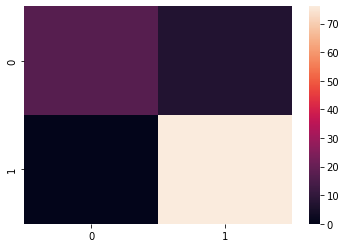

In [21]:
import seaborn as sns
sns.heatmap(cm)